--- 
# Part 1: Overview & EDA

--- 

# Problem Statement

Conducting analysis on your customer base and sending personalized campaigns to high value targets has massive benefits in any industry. Using unsupervised learning, I will seek to implement cluster analysis for customer segmentation and targeted marketing outreach.

# Contents

- [Overview](#Overview)
- [References](#References)
- [Data Import & Cleaning](#Part-2-:-Data-Import-&-Cleaning)
- [Exploratory Data Analysis](#Part-3:-Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Data Dictionary](#Data-Dictionary)

# Overview

Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately. The goal is to maximize the value of each customer to the business. In business-to-consumer marketing, companies like Starbucks often segment customers according to demographics that include:

- Age
- Gender
- Location (urban, suburban, rural)
- Products previously purchased from the company
- Other demographics like life stage (single, married, divorced, empty-nester, retired, etc.)

Why segment customers?
- Create and communicate targeted marketing messages that will resonate with specific groups of customers, but not with others (who will receive messages tailored to their needs and interests, instead).
- Select the best communication channel for the segment, which might be email, social media posts, radio advertising, or another approach, depending on the segment. 
- Identify ways to improve products or new product or service opportunities.
- Establish better customer relationships.
- Test pricing options.
- Focus on the most profitable customers.
- Improve customer service.
- Upsell and cross-sell other products and services.

There is simulated Starbucks customer data that includes transactions, demographics and offer data like BOGO offers.
This data was provided by Starbucks to simulate their customers and transactions to see if there are better approaches to sending customers specific promotional deals. The dataset includes 306,534 events related to 17,000 customers and 10 event types over the course of a 30-day experiment. One of the main tasks of this project is to synthesize these three different datasets for customer segmentation analysis and a deep dive into each cluster.

So what are the different types of customers that Starbucks has? Do people react to different discount promotions? Can Starbucks make more money on promotions if they cluster their customers appropriately? My analysis of Starbucks customers will answer what type of people make purchases at their stores and what promotional offers are most appropriate for the cluster they belong to.

**Workflow:**

1. EDA
2. Data Wrangling
3. Merge and Synthesize Cleaned Datasets
4. Calculate RMF Metrics and Conversion Rates from Offer to Transaction
5. Feature Scaling
6. Dimensionality Reduction: PCA
7. DBSCAN and K-Means
8. Transfer Learning - Build regression model using customer segments
9. More EDA
10. Business Insights & Recommendations


# References

1. Data Source: https://www.kaggle.com/ihormuliar/starbucks-customer-data
2. https://seifip.medium.com/starbucks-offers-advanced-customer-segmentation-with-python-737f22e245a4
3. https://www.barilliance.com/rfm-analysis/
4. https://formation.ai/blog/how-starbucks-became-1-in-customer-loyalty/
5. https://lifetimes.readthedocs.io/en/latest/
6. https://www.natasshaselvaraj.com/customer-segmentation-with-python/
7. https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6

# Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import calendar
import ast
from sklearn.preprocessing import LabelEncoder
    
pd.set_option('display.max_rows', None)
sns.set_palette('Greens_r')

# Data Import 

In [2]:
transcript = pd.read_csv('./data/transcript.csv')
portfolio = pd.read_csv('./data/portfolio.csv')
profile = pd.read_csv('./data/profile.csv')

transcript.head()

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [3]:
portfolio.head()

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
# Drop Unnamed index column
transcript.drop(columns = ['Unnamed: 0'], inplace = True)
portfolio.drop(columns = ['Unnamed: 0'], inplace = True)
profile.drop(columns = ['Unnamed: 0'], inplace = True)
profile.head()

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
transcript.shape, portfolio.shape, profile.shape

((306534, 4), (10, 6), (17000, 5))

# Portfolio Data

Contains 10 different promotional offers and information about each one including the promotional offer type, difficulty rating to achieve the promotion, duration of the offer, reward, and how the promotion was distributed to customers (channels).

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


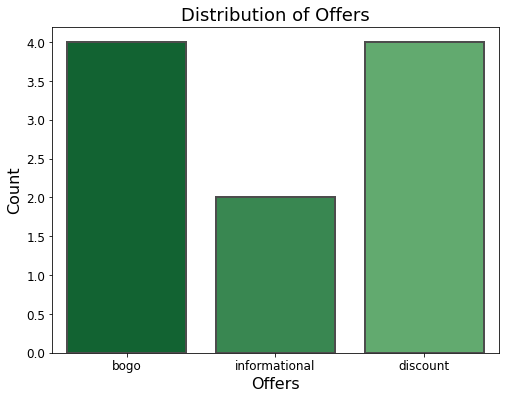

In [9]:
plt.figure(figsize = (8,6))
sns.countplot(data = portfolio, x = 'offer_type', edgecolor=".3", linewidth=2)
plt.title('Distribution of Offers', size = 18)
plt.ylabel('Count', size = 16)
plt.xlabel('Offers', size = 16)
plt.xticks(size = 12)
plt.yticks(size = 12);

Majority discount and bogo offers.

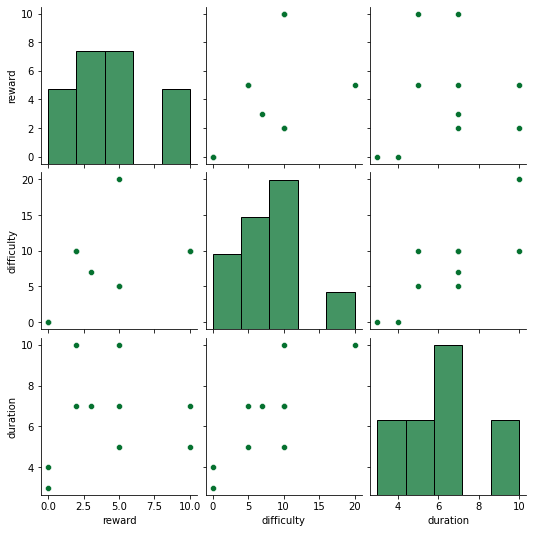

In [10]:
sns.pairplot(portfolio);

In [11]:
# Clarifying 'id' since we have customer_id and offer_id 
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [12]:
portfolio['channels'].value_counts()

['web', 'email', 'mobile', 'social']    4
['web', 'email', 'mobile']              3
['email', 'mobile', 'social']           2
['web', 'email']                        1
Name: channels, dtype: int64

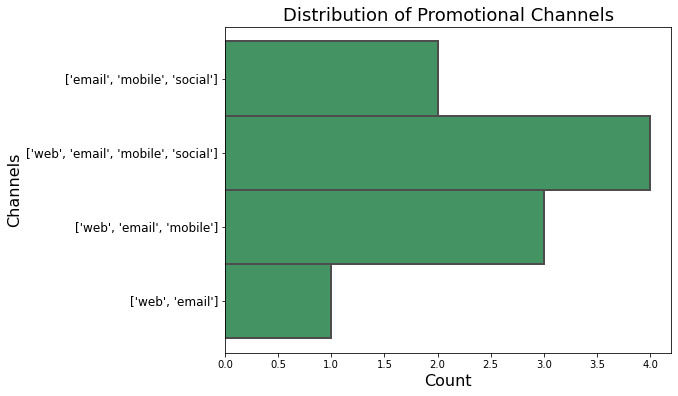

In [13]:
plt.figure(figsize = (8,6))
sns.histplot(portfolio, y = 'channels', edgecolor=".3", linewidth=2)
plt.title('Distribution of Promotional Channels', size = 18)
plt.ylabel('Channels', size = 16)
plt.xlabel('Count', size = 16)
plt.yticks(size = 12);

Most offers use all 4 channel types for promotion.

In [14]:
# Unnesting the channels column and giving it a binary value if the offer contains that channel
def email(portfolio):
    if 'email' in portfolio['channels']:
        val = 1
    else:
        val = 0
    return val

def mobile(portfolio):
    if 'mobile' in portfolio['channels']:
        val = 1
    else:
        val = 0
    return val

def web(portfolio):
    if 'web' in portfolio['channels']:
        val = 1
    else:
        val = 0
    return val

def social(portfolio):
    if 'social' in portfolio['channels']:
        val = 1
    else:
        val = 0
    return val

portfolio['email'] = portfolio.apply(email, axis=1)
portfolio['mobile'] = portfolio.apply(mobile, axis=1)
portfolio['web'] = portfolio.apply(web, axis=1)
portfolio['social'] = portfolio.apply(social, axis=1)
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,web,social
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [15]:
portfolio['offer_id'].unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [16]:
portfolio['offer_id_modified'] = portfolio['offer_id'].replace({'ae264e3637204a6fb9bb56bc8210ddfd': 'offer_1', 
                                                               '4d5c57ea9a6940dd891ad53e9dbe8da0': 'offer_2',
                                                               '3f207df678b143eea3cee63160fa8bed': 'offer_3',
                                                               '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'offer_4',
                                                               '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'offer_5',
                                                               '2298d6c36e964ae4a3e7e9706d1fb8c2': 'offer_6',
                                                               'fafdcd668e3743c1bb461111dcafc2a4': 'offer_7',
                                                               '5a8bc65990b245e5a138643cd4eb9837': 'offer_8',
                                                               'f19421c1d4aa40978ebb69ca19b0e20d': 'offer_9',
                                                               '2906b810c7d4411798c6938adc9daaa5': 'offer_10'})
portfolio['offer_id_modified'].unique()

array(['offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5', 'offer_6',
       'offer_7', 'offer_8', 'offer_9', 'offer_10'], dtype=object)

In [18]:
final_portfolio = portfolio.drop(columns = ['channels',
                                            'offer_id_modified'
                                           ])

final_portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,web,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0


In [19]:
final_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   difficulty  10 non-null     int64 
 2   duration    10 non-null     int64 
 3   offer_type  10 non-null     object
 4   offer_id    10 non-null     object
 5   email       10 non-null     int64 
 6   mobile      10 non-null     int64 
 7   web         10 non-null     int64 
 8   social      10 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 848.0+ bytes


**Observations:**
- channels and offer_type need to be one hot encoded
- portfolio['id'] == 'offer_id' in transcript['value'] so I renamed 'id' to 'offer_id'
- instead of the string of characters for offer_id I created a column that has a more interpretable offer name like offer_1, offer_2 etc
- unnested the list in channels

# Profile Data

17,000 records where each row represents a customer, their gender, age, income, and when they became member of the rewards program.

In [20]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [21]:
# Convert dates from int to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

profile.dtypes

gender                      object
age                          int64
id                          object
became_member_on    datetime64[ns]
income                     float64
dtype: object

In [22]:
# Breaking up the date from became_member_on to be able to use for EDA
# Split out into year, month and day, and calculate total membership_days using today
profile['year'] = profile['became_member_on'].dt.year
profile['month'] = profile['became_member_on'].dt.month
profile['day']=profile['became_member_on'].dt.day_name()
profile['membership_days'] = (pd.to_datetime('today') - profile['became_member_on']).astype('timedelta64[D]').astype(int)
profile.head(3)

,gender,age,id,became_member_on,income,year,month,day,membership_days
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,Sunday,1677
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,Saturday,1524
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,Thursday,1162


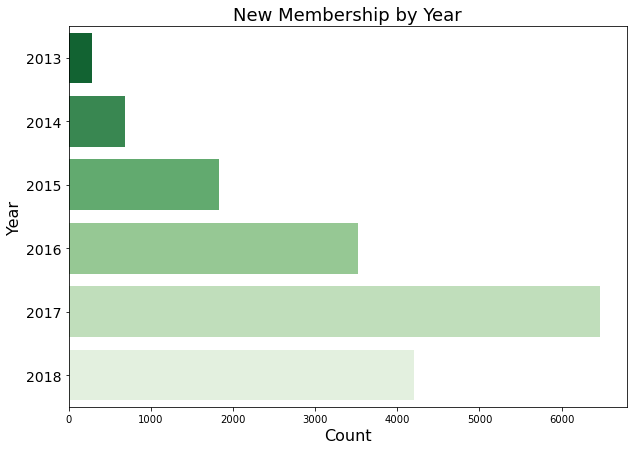

In [24]:
plt.figure(figsize=(10,7))
ax = sns.countplot(y="year", data=profile)
plt.title('New Membership by Year', size = 18)
plt.xlabel('Count', size = 16)
plt.yticks(size = 14)
plt.ylabel('Year', size = 16)
plt.savefig('./images/membership_freq.png');

2017 at first glance had more membership sign ups for the rewards program than in 2018.

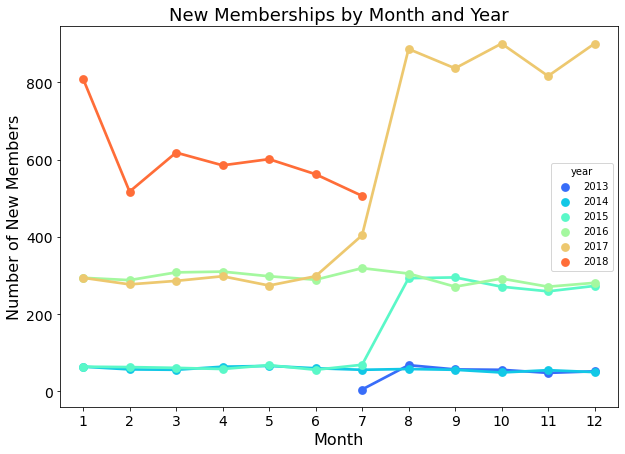

In [25]:
membership_subs = profile[profile['year']>= 2013].groupby(['year','month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(10,7))
sns.pointplot(x="month", y="id", hue="year", data = membership_subs, palette = 'rainbow')
plt.ylabel('Number of New Members', size = 16)
plt.xlabel('Month', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.title('New Memberships by Month and Year', size = 18)
plt.savefig('./images/membership_month_year.png');

Data for 2018 & 2013 aren't a full year which is why 2018 might be lower than total new memberships for 2017.

In [25]:
# Change month number to name
# profile['month'] = profile['month'].apply(lambda x: calendar.month_abbr[x])

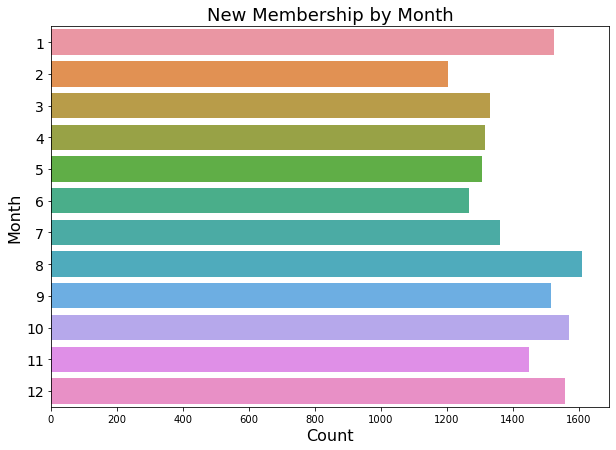

In [28]:
plt.figure(figsize=(10,7))
ax = sns.countplot(y = profile['month'])
plt.title('New Membership by Month', size = 18)
plt.xlabel('Count', size = 16)
plt.yticks(size = 14)
plt.ylabel('Month', size = 16)
plt.savefig('./images/membership_month.png');

August had the most new membership sign ups.

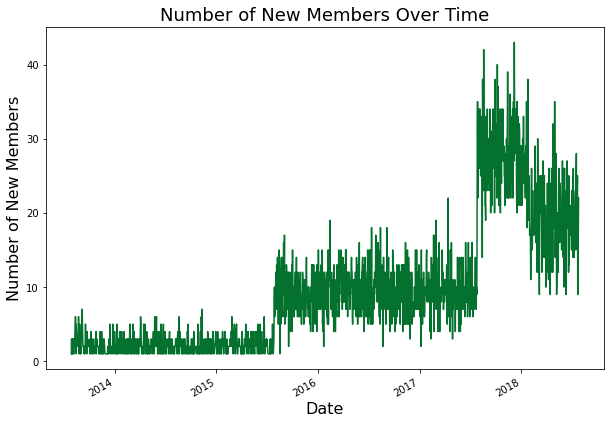

In [33]:
# Number of sign ups each day
profile['became_member_on'].value_counts().plot(kind = 'line', figsize = (10,7))
plt.xlabel('Date', size = 16)
plt.ylabel('Number of New Members', size = 16)
plt.title('Number of New Members Over Time', size =18)
plt.savefig('./images/membership_timeseries.png');

Two big jumps in membership signups, a little over halfway through 2015 and 2017 respectivly. 

In [31]:
# Impute NaN genders with 'Blank' 
# Not filling with 'O' (other) group as it could represent gender nonbinary 
# which is not the same as customers just leaving that field blank
profile['gender_modified'] = profile['gender'].fillna('Blank')

profile['gender_modified'].value_counts(normalize = True)

M        0.499059
F        0.360529
Blank    0.127941
O        0.012471
Name: gender_modified, dtype: float64

Almost 50% of memberships identify as male, 36% female, 12.7% left gender blank, and 1.2% marked other

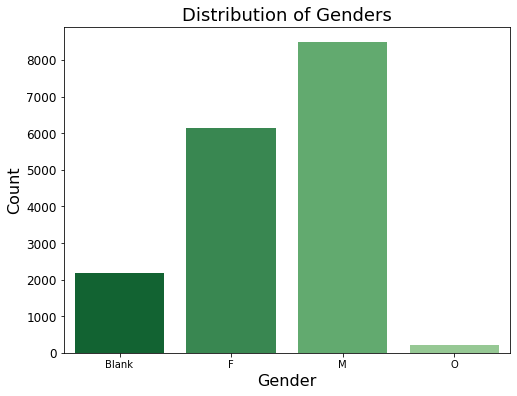

In [34]:
plt.figure(figsize = (8,6))
sns.countplot(data=profile,x='gender_modified')
plt.title('Distribution of Genders', size = 18)
plt.ylabel('Count', size = 16)
plt.xlabel('Gender', size = 16)
plt.yticks(size = 12)
plt.savefig('./images/gender_dist.png');

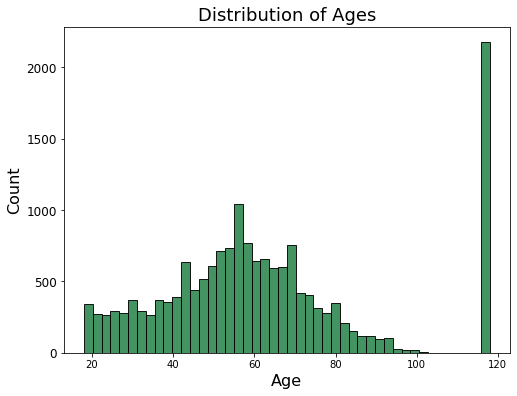

In [35]:
plt.figure(figsize = (8,6))
sns.histplot(data=profile,x='age')
plt.title('Distribution of Ages', size = 18)
plt.ylabel('Count', size = 16)
plt.xlabel('Age', size = 16)
plt.yticks(size = 12);

Pretty significant outlier at 118 years old - these all correspond with the NaNs we saw in the gender column.

In [36]:
# Fix outlier in Age
profile[profile['age']==118]['gender'].value_counts()

Series([], Name: gender, dtype: int64)

In [37]:
# Imputing with random sampling of age to maintain distribution
profile['age_modified'] = profile['age'].apply(lambda x: np.random.choice(profile[profile['age'] != 118]['age']) 
                                               if x == 118 else x)

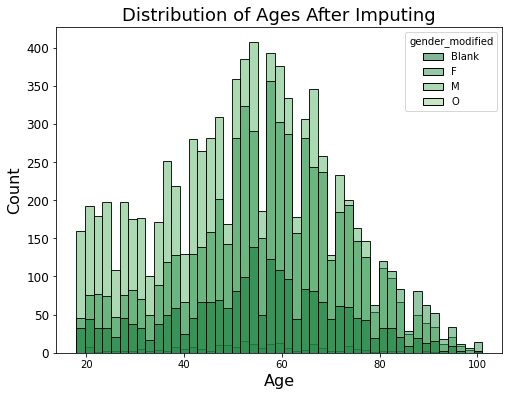

In [38]:
plt.figure(figsize = (8,6))
sns.histplot(data=profile,x='age_modified', hue='gender_modified')
plt.title('Distribution of Ages After Imputing', size = 18)
plt.ylabel('Count', size = 16)
plt.xlabel('Age', size = 16)
plt.yticks(size = 12)
plt.savefig('./images/age_gender_dist.png');

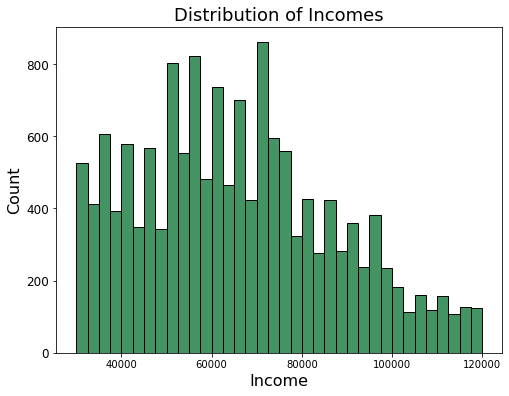

In [39]:
plt.figure(figsize = (8,6))
sns.histplot(data=profile,x='income')
plt.title('Distribution of Incomes', size = 18)
plt.ylabel('Count', size = 16)
plt.xlabel('Income', size = 16)
plt.yticks(size = 12);

In [41]:
# Income nulls also correspond with the age outlier and gender NaNs
profile[profile['income'].isnull()].groupby('gender').count()['income']

Series([], Name: income, dtype: int64)

In [42]:
# Impute empty incomes with random sampling of non null values
profile['income_modified']= profile['income'].apply(
    lambda x: np.random.choice(profile['income'].dropna().values) if np.isnan(x) else x).astype(int)

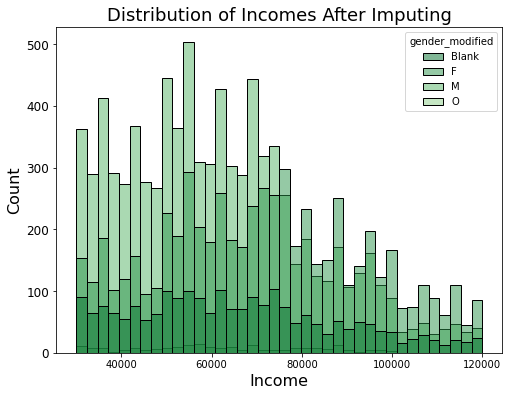

In [43]:
plt.figure(figsize = (8,6))
sns.histplot(data=profile,x='income_modified', hue='gender_modified')
plt.title('Distribution of Incomes After Imputing', size = 18)
plt.ylabel('Count', size = 16)
plt.xlabel('Income', size = 16)
plt.yticks(size = 12)
plt.savefig('./images/income_gender_dist.png');

In [44]:
profile.describe()

,age,income,year,month,membership_days,age_modified,income_modified
count,17000.000000,14825.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,62.531412,65404.991568,2016.635000,6.683529,1665.449882,54.420059,65429.411765
std,26.738580,21598.299410,1.177624,3.487098,411.223904,17.357461,21663.928572
min,18.000000,30000.000000,2013.000000,1.000000,1148.000000,18.000000,30000.000000
25%,45.000000,49000.000000,2016.000000,4.000000,1356.000000,43.000000,49000.000000
50%,58.000000,64000.000000,2017.000000,7.000000,1506.000000,55.000000,64000.000000
75%,73.000000,80000.000000,2017.000000,10.000000,1939.000000,66.000000,80000.000000
max,118.000000,120000.000000,2018.000000,12.000000,2971.000000,101.000000,120000.000000


Max age is now 101, min age is 18.

In [45]:
final_profile = profile.drop(columns = ['gender', 'age', 'income'])

In [46]:
# Rename 'id' to 'customer_id' and other modified columns just for more clarity
final_profile.rename(columns={'id': 'customer_id', 
                        'gender_modified': 'gender',
                        'age_modified': 'age',
                        'income_modified': 'income'}, inplace=True)
final_profile.head()

,customer_id,became_member_on,year,month,day,membership_days,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,2017,2,Sunday,1677,Blank,42,42000
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2017,7,Saturday,1524,F,55,112000
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,2018,7,Thursday,1162,Blank,58,43000
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,2017,5,Tuesday,1591,F,75,100000
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,2017,8,Friday,1504,Blank,27,108000


In [47]:
# Make sure there aren't any duplicate customer profiles(rows)
len(np.unique(final_profile['customer_id'])) == len(final_profile)

True

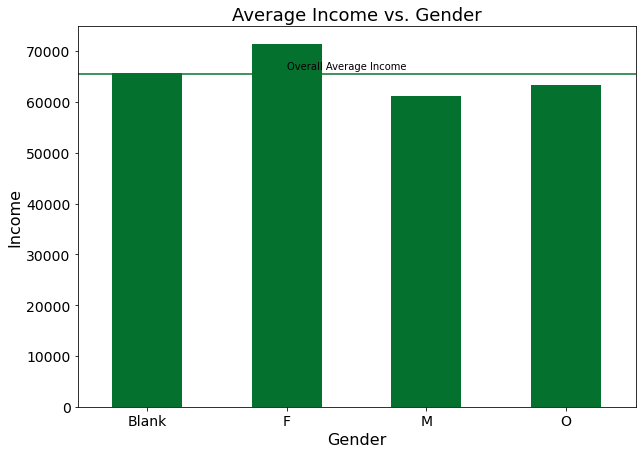

In [48]:
mean_income = final_profile['income'].mean()
gender_income = final_profile.groupby('gender', as_index=False).agg({'income':'mean'})
gender_income.plot(kind = 'bar', x = 'gender', y = 'income', legend=False, figsize=(10,7))
plt.hlines(mean_income, -100 , 1000)
plt.ylabel('Income', size = 16)
plt.xlabel('Gender', size = 16)
plt.title('Average Income vs. Gender', size = 18)
plt.xticks(rotation = 0, size = 14)
plt.yticks(size = 14)
plt.text(1, mean_income + 1000, 'Overall Average Income')
plt.savefig('./images/income_gender.png');

**Observations:**
- 'became_member_on' changed to a datetime data type
- 'age' had 2175 outliers of age 118. These were all from the NaN gender group and NaN incomes- imputed using the avg age of the 'O' gender group
- 'gender' had 2175 NaNs I imputed with the 'O' group
- 'income' also had 2175 NaNs so I imputed using the avg income of the 'O' gender group
- profile['id'] == transcript['person']
- Need to one hot encode 'gender', 'year', 'month', 'day'
- The majority of customers in the dataset are male.
- Data for 2018 isn't a full year which is why it's lower than total new memberships for 2017.

# Transcript Data
Records show the different statuses of the promotional offers that a customer received, for example offer_received, offer_viewed, offer_completed in addition to the transactions for each customer. 

In [49]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [50]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [51]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


Transactions and offers in this datatset.

In [52]:
transcript['event'].value_counts(normalize=True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [53]:
# transcript['person'] == profile['id']
# Change column name from 'person' to 'id' in order to merge the dataframes later
transcript.rename(columns={'person':'customer_id'}, inplace=True)

In [54]:
# Kept getting error below because 'value' is being read as a string not dictionary
transcript['value'].apply(type).head()

0    <class 'str'>
1    <class 'str'>
2    <class 'str'>
3    <class 'str'>
4    <class 'str'>
Name: value, dtype: object

In [55]:
# Reference: https://stackoverflow.com/questions/39169718/convert-string-to-dict-then-access-keyvalues-how-to-access-data-in-a-class
transcript['value'] = transcript['value'].astype('str')
transcript['value'] = transcript['value'].apply(lambda x: ast.literal_eval(x))
transcript = transcript.apply(pd.Series)

# Extract out just the actual 'offer_id' and 'amount' from 'value' column
transcript['value_type'] = transcript['value'].map(lambda x: list(x.keys())[0])
transcript['value'] = transcript['value'].map(lambda x: list(x.values())[0])
transcript.tail()

,customer_id,event,value,time,value_type
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,1.59,714,amount
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,9.53,714,amount
306531,a00058cf10334a308c68e7631c529907,transaction,3.61,714,amount
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,3.53,714,amount
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,4.05,714,amount


In [56]:
transcript.head()

,customer_id,event,value,time,value_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer id


'value' now either has the transaction amount or the offer_id

### Split out transactions from offers originally
Keeping in case I want to use this for EDA later

In [53]:
# Simplify the offer id to match the portfolio['offer_id_modified']

# if transcript['value_type']=='offer id':
#     transcript['value'] = transcript['value'].replace({'ae264e3637204a6fb9bb56bc8210ddfd': 'offer_1', 
#                                                            '4d5c57ea9a6940dd891ad53e9dbe8da0': 'offer_2',
#                                                            '3f207df678b143eea3cee63160fa8bed': 'offer_3',
#                                                            '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'offer_4',
#                                                            '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'offer_5',
#                                                            '2298d6c36e964ae4a3e7e9706d1fb8c2': 'offer_6',
#                                                            'fafdcd668e3743c1bb461111dcafc2a4': 'offer_7',
#                                                            '5a8bc65990b245e5a138643cd4eb9837': 'offer_8',
#                                                            'f19421c1d4aa40978ebb69ca19b0e20d': 'offer_9',
#                                                            '2906b810c7d4411798c6938adc9daaa5': 'offer_10'})
# else:
#     transcript['value'] = transcript['value']

In [55]:
# # Used to extract out just the actual 'offer_id' and 'amount' from 'value' column as separate dfs
# transaction = transcript.loc[transcript['event'] == 'transaction']
# offer = transcript.loc[transcript['event'] != 'transaction']

# pattern = re.compile('[\d]+.[\d]+')
# transaction['value'] = transaction['value'].apply(pattern.findall).str.get(0)
# transaction.rename(columns={'value': 'amount'}, inplace=True)
# transaction = transaction.astype(dtype={'amount': 'float'})

# pattern2 = re.compile('[\w]+[\w]+')
# offer['value'] = offer['value'].apply(pattern2.findall).str.get(2)
# offer.rename(columns={'value': 'offer id'}, inplace=True)
# offer = offer.astype(dtype={'offer id': 'object'})

# # Simplify the offer id to match the portfolio['offer_id_modified']
# offer['offer_id_modified'] = offer['offer id'].replace({'ae264e3637204a6fb9bb56bc8210ddfd': 'offer_1', 
#                                                                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'offer_2',
#                                                                '3f207df678b143eea3cee63160fa8bed': 'offer_3',
#                                                                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'offer_4',
#                                                                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'offer_5',
#                                                                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'offer_6',
#                                                                'fafdcd668e3743c1bb461111dcafc2a4': 'offer_7',
#                                                                '5a8bc65990b245e5a138643cd4eb9837': 'offer_8',
#                                                                'f19421c1d4aa40978ebb69ca19b0e20d': 'offer_9',
#                                                                '2906b810c7d4411798c6938adc9daaa5': 'offer_10'})
# #offer['offer_id_modified'].unique()
# offer = offer.drop(columns =['offer id'])
# offer.head()

**Observations:**
- 'time' convert to days possibly?
- transcript['person'] == profile['customer_id']
- 'offer_id' in transcript['value'] == portfolio['offer_id']
- 'value' is a dict of strings - either an offer id or transaction amount depending on the record. From 'value' extracted out just the actual 'offer_id' and 'amount'
- Need to one hot encode 'event', 'offer_id_modified'
- The offer_id can have the offer_recieved, offer_reviewed, and the offer_compelted.

# Merge Datasets
Merge dataframes so that we have each customer with all of their personal demographics, transactional aggregates, and promotional aggregates. 

In [58]:
final_portfolio.shape, final_profile.shape, transcript.shape

#offer.shape, transaction.shape

((10, 9), (17000, 9), (306534, 5))

In [59]:
final_portfolio.columns, final_profile.columns, transcript.columns

(Index(['reward', 'difficulty', 'duration', 'offer_type', 'offer_id', 'email',
        'mobile', 'web', 'social'],
       dtype='object'),
 Index(['customer_id', 'became_member_on', 'year', 'month', 'day',
        'membership_days', 'gender', 'age', 'income'],
       dtype='object'),
 Index(['customer_id', 'event', 'value', 'time', 'value_type'], dtype='object'))

### Merge Same Offer Received & Completed Combos

In [91]:
# Merging 'offer received' and 'offer completed' for the same offer/customer combo
completed_offers = pd.merge(
                    transcript[transcript['event'] == 'offer received'],
                    transcript[transcript['event'] == 'offer completed'],
                    how = 'left',
                    left_on = ['customer_id','value'],
                    right_on = ['customer_id','value'])

# 'time' is int for one and float for other - convert both to float
completed_offers['time_y'] = completed_offers['time_y'].apply(lambda x: float(x))
completed_offers['time_x'] = completed_offers['time_x'].apply(lambda x: float(x))
completed_offers.tail()

,customer_id,event_x,value,time_x,value_type_x,event_y,time_y,value_type_y
86427,d087c473b4d247ccb0abfef59ba12b0e,offer received,ae264e3637204a6fb9bb56bc8210ddfd,576.0,offer id,offer completed,636.0,offer_id
86428,cb23b66c56f64b109d673d5e56574529,offer received,2906b810c7d4411798c6938adc9daaa5,576.0,offer id,offer completed,156.0,offer_id
86429,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,576.0,offer id,NaN,NaN,NaN
86430,9dc1421481194dcd9400aec7c9ae6366,offer received,ae264e3637204a6fb9bb56bc8210ddfd,576.0,offer id,offer completed,594.0,offer_id
86431,e4052622e5ba45a8b96b59aba68cf068,offer received,3f207df678b143eea3cee63160fa8bed,576.0,offer id,NaN,NaN,NaN


In [92]:
completed_offers.shape

(86432, 8)

### Merge transcript with final_portfolio promotional info

In [93]:
# Transactions are dropped from the merge since they don't have an offer_id
full_offers = pd.merge(transcript,
                       final_portfolio, 
                       how = 'inner',
                       left_on = 'value', 
                       right_on = 'offer_id')

full_offers['net_reward'] = full_offers['reward'] - full_offers['difficulty']
full_offers.drop(columns=['value'], inplace=True)
full_offers.tail()

,customer_id,event,time,value_type,reward,difficulty,duration,offer_type,offer_id,email,mobile,web,social,net_reward
167576,642b6f1bf61040efb73e1859cf00e79e,offer viewed,714,offer id,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,0
167577,5a3f7fcb450a4cb693ab5267b4d49b40,offer viewed,714,offer id,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,0
167578,ec1761735b034ae8874bc979f0cd5862,offer viewed,714,offer id,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,0
167579,d56386cf344c4829bbf420d1895dca37,offer viewed,714,offer id,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,0
167580,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,714,offer id,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,0


In [94]:
full_offers.shape

(167581, 14)

In [95]:
# We only want the offers that were in the same timeframe
final_completed_offers = completed_offers[
    (
    (completed_offers['time_y'] <= (completed_offers['time_x'] + 20)) # Completion date is within max time frame
        & (completed_offers['time_y'] >= completed_offers['time_x'])  # Completion date is after offer received
    )
    | # or 
    (pd.isnull(completed_offers['event_y']) == True) # Null values to show offers that were never completed
        ][['customer_id','time_x','value','event_y','time_y']]

final_completed_offers['DaysToCompleteOffer'] = final_completed_offers['time_y'] - final_completed_offers['time_x'] 
final_completed_offers['CompletedOffer'] = final_completed_offers['event_y'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
final_completed_offers.tail()

,customer_id,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
86425,f924927e7f844ecebf87eef93f4d2688,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86426,a57890c3bbb7463e9018abb7fecadb15,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86429,6d5f3a774f3d4714ab0c092238f3a1d7,576.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1
86431,e4052622e5ba45a8b96b59aba68cf068,576.0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,0


In [62]:
overall_offers_df = offers_final_df.groupby(['offer_type','difficulty','reward'], as_index = False).agg({
    'CompletedOffer':['mean', 'sum'] # Average of time they complete the order
    , 'DaysToCompleteOffer':'mean' # Average days it takes for someone to complete the order
    , 'NetReward': 'max' # The net reward (should be just the reward - difficulty)
})

overall_offers_df.columns.droplevel(1)
overall_offers_df.columns = ['offer_type','difficulty','reward','CompletedOffers','TotalCompletions'
                            , 'AvgDaysToComplete','NetReward']
overall_offers_df['NetWorth'] = (overall_offers_df['CompletedOffers'] * overall_offers_df['NetReward']) * -1
final_overall_offers_df = overall_offers_df[overall_offers_df['offer_type'] != 'informational']
final_overall_offers_df

,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToComplete,NetReward,NetWorth
0,bogo,5,5,0.308293,2606,8.638526,0,-0.000000
1,bogo,10,10,0.217532,2149,9.001396,0,-0.000000
2,discount,7,3,0.383878,1362,8.938326,-4,1.535513
3,discount,10,2,0.279512,2060,8.906796,-8,2.236092
4,discount,20,5,0.090034,393,9.511450,-15,1.350515


In [63]:
all_transactions = transcript[transcript['value_type'] == 'amount']
all_transactions['value'] = all_transactions['value'].apply(lambda x: float(x))
all_transactions.head()

<ipython-input-63-a41db2bae588>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_transactions['value'] = all_transactions['value'].apply(lambda x: float(x))


,customer_id,event,value,time,value_type
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0,amount
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0,amount
12659,54890f68699049c2a04d415abc25e717,transaction,13.23,0,amount
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0,amount
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0,amount


In [66]:
all_transactions.shape, final_overall_offers_df.shape, final_profile.shape, test_person_transactions.shape

((138953, 5), (5, 8), (17000, 9), (36, 6))

In [97]:
#Reference: https://github.com/anchorP34/Starbucks-Customer-Clusters
# df_all_customers = pd.DataFrame(columns = ['customer_id', 'discount_total_offers', 'discount_completion_pct',
#        'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
#        'discount_avg_completion_days', 'discount_avg_net_reward',
#        'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
#        'bogo_max_completion_days', 'bogo_avg_completion_days',
#        'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
#        'income', 'member_date', 'total_transactions', 'min_transaction_day',
#        'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
#        'median_days_between_purchases', 'avg_days_between_purchases'])

# for person in np.unique(final_profile['customer_id']):
    
#     # Get Individual profile info
#     personal_profile = final_profile[final_profile['customer_id'] == person][['customer_id','age','gender','income','became_member_on']]
    
#     # Get transaction aggregates
#     personal_transactions = all_transactions[all_transactions['customer_id'] == person].reset_index()
#     if len(personal_transactions) > 0:
#         personal_transactions['DaysFromLastPurchase'] = personal_transactions.time.diff()
#         personal_transactions.iloc[0, -1] = test_person_transactions.loc[0, 'time']

#         personal_agg_trans = personal_transactions.groupby('customer_id', as_index = False).agg(
#         {
#             'time': ['count','min','max'] # First and Last Purchase
#             , 'value': ['mean', 'sum'] # Average Purchase Amount, total purchase amount
#             , 'DaysFromLastPurchase': ['median', 'mean'] # Average days between purchases  
#         })
#         personal_agg_trans.columns = personal_agg_trans.columns.droplevel(1) # Gets rid of the multi leveling columns
#         personal_agg_trans.columns = ['customer_id', 'total_transactions','min_transaction_day','max_transaction_day'
#                                       , 'avg_transaction','total_transaction_amount','median_days_between_purchases'
#                                       ,'avg_days_between_purchases']
#     else:
#         null_array = [person, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
#         personal_agg_trans = pd.DataFrame([null_array]
#                                          , columns = ['customer_id', 'total_transactions','min_transaction_day'
#                                                       ,'max_transaction_day'
#                                                       , 'avg_transaction','median_days_between_purchases'
#                                                       ,'avg_days_between_purchases'])
        
        
#     # Bring together the transaction aggregates and the profile values
#     personal_df_1 = pd.merge(personal_profile, personal_agg_trans
#                              , how = 'inner', left_on = 'customer_id', right_on = 'customer_id')
# #    personal_df_1.drop('customer_id', axis = 1, inplace = True) # Get rid of the ID column


#     # Look at the different promotions that the person interacted with
#     # Using global variables to join data in the next step
#     for offer_type in ['discount','bogo']:
#         globals()[offer_type + '_df'] =  offers_final_df[(offers_final_df['customer_id'] == person)
#                        & (offers_final_df['offer_type'] == offer_type)
#                        ].groupby('customer_id', as_index = False).agg({
#                                                         'CompletedOffer':['count','mean','sum']
#                                                         , 'DaysToCompleteOffer': ['min','max','mean']
#                                                         , 'NetReward': ['mean']
#                                                     })
        
#         globals()[offer_type + '_df'].columns = globals()[offer_type + '_df'].columns.droplevel(1)
#         globals()[offer_type + '_df'].columns = ['customer_id', offer_type + '_total_offers'
#                                     ,offer_type + '_completion_pct', offer_type + '_completed_offers'
#                                    , offer_type + '_min_completion_days',offer_type + '_max_completion_days'
#                                     ,offer_type + '_avg_completion_days', offer_type + '_avg_net_reward']
        
#         if len(globals()[offer_type + '_df']) == 0:
#             null_array = [person,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan]
#             globals()[offer_type + '_df'] = globals()[offer_type + '_df'].append(
#                 dict(zip(globals()[offer_type + '_df'].columns, null_array)), ignore_index=True
#             )
    
#     # Bring together the bogo and discount values, and include the number of informational promos they received
#     bogo_and_discounts = pd.merge(discount_df, bogo_df)
#     bogo_and_discounts['informational_promotions'] = len(offers_final_df[(offers_final_df['customer_id'] == person)
#                                                                & (offers_final_df['offer_type'] == 'informational')])
    
#     # Bring everything together
#     person_final = pd.merge(bogo_and_discounts, personal_df_1)
    
#     # Add personal df to the rest of the customer dataframe
#     df_all_customers = df_all_customers.append(person_final)

In [65]:
# Check that there are the same amount of customers in both dfs
len(df_all_customers) == len(final_profile)

False

In [ ]:
# final_offers = offer.merge(final_profile, how= 'inner', on='customer_id')
# final_offers = final_offers.merge(final_portfolio, left_on='offer_id_modified', right_on='offer_id_modified')
# #final_offers.set_index('offer_id_modified', inplace=True)
# final_offers.head()

In [ ]:
# final_offers = offer.merge(final_profile, left_on='customer_id', right_on='customer_id')
# final_offers = final_offers.merge(final_portfolio, left_on='offer_id_modified', right_on='offer_id_modified')
# #final_offers.set_index('offer_id_modified', inplace=True)
# final_offers.head()

In [ ]:
final_offers['event'].value_counts()

In [ ]:
final_offers.rename(columns=
                  {'time':'time_hours',
                   'offer_id_modified': 'offer_id'
                  }, inplace=True)

In [ ]:
final_offers.shape

In [ ]:
final_transactions = transaction.merge(final_profile, left_on='customer_id', right_on='customer_id')
final_transactions.drop(['event'], axis=1, inplace=True)
final_transactions.head()

There can be multiple transactions for the same customer_id.

In [ ]:
final_transactions.rename(columns=
                  {'time': 'time_hours'
                  }, inplace=True)

In [ ]:
final_transactions.shape

## One-hot encode rest of categorical features

For final_offers: event, offer_id, gender, offer_type

For final_transactions: gender

In [ ]:
offers_dummy_cols =final_offers.select_dtypes(include=['object'])
offers_dummy_cols.columns

In [ ]:
offers_dummy_cols = offers_dummy_cols.drop(columns=['customer_id'])

In [ ]:
# Don't use drop_first on dummified columns for clustering - you want all classes represented
final_offers = pd.get_dummies(final_offers, columns=offers_dummy_cols.columns)
final_offers = pd.get_dummies(final_offers, columns=['month'])
final_offers.head()

In [ ]:
final_offers.shape

In [ ]:
final_offers.columns

In [ ]:
transactions_dummy_cols =final_transactions.select_dtypes(include=['object'])
transactions_dummy_cols.columns

In [ ]:
transactions_dummy_cols = transactions_dummy_cols.drop(columns=['customer_id'])

In [ ]:
final_transactions = pd.get_dummies(final_transactions, columns=transactions_dummy_cols.columns)
final_transactions = pd.get_dummies(final_transactions, columns=['month'])
final_transactions.head()

In [ ]:
final_transactions.shape

## More Feature Engineering

In [ ]:
# Add offer receipt, view and completion time columns

final_offers['time_hours'] = final_offers['time_hours'] + 0.5
final_offers['received_time'] = final_offers['event_offer received'] * final_offers['time_hours']
final_offers['viewed_time'] = final_offers['event_offer viewed'] * final_offers['time_hours']
final_offers['completed_time'] = final_offers['event_offer completed'] * final_offers['time_hours']
final_offers.head()

## Save Final Cleaned & Merged Files

In [ ]:
final_offers.to_csv('./data/final_offers_clean.csv', index = False)
final_transactions.to_csv('./data/final_transactions_clean.csv', index = False)

## More EDA

In [ ]:
# Check for repeat offers?
final_offers[final_offers.duplicated(subset=['offer_id', 'customer_id'], keep=False)].head()

There can be duplicate offers for the different events for the same customer_id - offer received and offer viewed events

In [ ]:
# Create a time group column and bin by certain ranges of days
offer['time_group'] = pd.cut(x=offer['time'], bins=[0, 100, 200, 300, 400, 500,600,700,800], include_lowest=True,
                    labels=['0-100 days', '100-200 days', '200-300 days', '300-400 days', '400-500 days', 
                            '500-600 days', '600-700 days', '700-800 days'])

transaction['time_group'] = pd.cut(x=transaction['time'], bins=[0, 100, 200, 300, 400, 500,600,700,800], include_lowest=True,
                    labels=['0-100 days', '100-200 days', '200-300 days', '300-400 days', '400-500 days', 
                            '500-600 days', '600-700 days', '700-800 days'])

In [ ]:
fig = plt.figure(figsize = (10,7))
sns.countplot(x='time_group',data=offer)
plt.xticks(rotation=30)
plt.title('No. of Offers in the Timespan', size = 18)
plt.xlabel('Timespan Group', size = 16)
plt.ylabel('Count', size = 16)
plt.savefig('./images/offers_timespan.png');

In [ ]:
fig = plt.figure(figsize = (10,7))
sns.countplot(x='time_group',data=transaction)
plt.xticks(rotation=30)
plt.title('No. of Transactions in the Timespan', size = 18)
plt.xlabel('Timespan Group', size = 16)
plt.ylabel('Count', size = 16);
plt.savefig('./images/transactions_timespan.png');

In [ ]:
# Create new age_group column by binning Age into different groups
profile['age_group'] = pd.cut(x=profile['age_modified'], bins=[18, 20, 40, 60, 80, 101],
                    labels=['Youth(0-19)', 'Young_Adult(20-39)', 'Middle-Age(40-59)',
                            'Senior(60-79)', 'Geriatric(80-100)'], include_lowest=True)

# profile['age_group'] = pd.cut(x=profile['age_modified'], bins=[18, 20, 40, 60, 80, 101],
#                     labels=[1,2,3,4,5], include_lowest=True)
profile['age_group'].value_counts(normalize=True)

In [ ]:
fig = plt.figure(figsize = (10,7))
sns.countplot(x='age_group',data=profile)
plt.xticks(rotation=30)
plt.title('Age Groups of Starbucks Customers', size = 18)
plt.xlabel('Age Group', size = 16)
plt.ylabel('Count', size = 16)
plt.savefig('./images/age_groups.png');

In [ ]:
profile.groupby('gender_modified').sum()['income_modified'].plot(kind='bar')
plt.title('Total Income per Gender')
plt.ylabel('Income')
plt.xlabel('Gender');

Total income for Males is higher even though the number of females in the higher income (78k and above) are higher than males.

In [ ]:
# Membership registration through the years
profile['year'].value_counts().sort_index().plot()
plt.xlabel('Year')
plt.ylabel('New Members')
plt.title('Loyalty Program Registration per Year')

2017 was the highest year then membership declined the following year in 2018.

## Data Dictionary

|Feature|Type|Description|
|---|---|---|
|**Id**|*int*|Identification number for the property.|
|**SalePrice**|*float*|The property's sale price in dollars. This is the target variable|
|**Total SF**|*float*|Total combined sqft of livable space|